# Force-200: MICE (max_iter=10), EDA

In [1]:
# import libraries
import numpy as np
import pandas as pd

import json

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno as msno

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import KFold, GroupKFold

from sklearn.model_selection import ParameterGrid

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time


# 1. Data Pre-processing

## 1.1. Data Loading

In [2]:
# force train dataset
train = pd.read_csv(filepath_or_buffer='force_train.csv', sep=';')

# force test dataset
test = pd.read_csv(filepath_or_buffer='force_test.csv', sep=';')


## 1.2. Data Information

In [3]:
# train dataset shape and number of wells
print('TRAIN-SET:')
print(f"   - Number of Samples: {train.shape[0]}")
print(f"   - Number of Features: {train.shape[1]}")
print(f"   - Number of Wells: {len(train['WELL'].unique())}\n")

# test dataset shape and number of wells
print('TEST-SET:')
print(f"   - Number of Samples: {test.shape[0]}")
print(f"   - Number of Features: {test.shape[1]}")
print(f"   - Number of Wells: {len(test['WELL'].unique())}\n")

TRAIN-SET:
   - Number of Samples: 1170511
   - Number of Features: 29
   - Number of Wells: 98

TEST-SET:
   - Number of Samples: 122397
   - Number of Features: 29
   - Number of Wells: 10



In [4]:
# general information about the dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170511 entries, 0 to 1170510
Data columns (total 29 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   WELL                               1170511 non-null  object 
 1   DEPTH_MD                           1170511 non-null  float64
 2   X_LOC                              1159736 non-null  float64
 3   Y_LOC                              1159736 non-null  float64
 4   Z_LOC                              1159736 non-null  float64
 5   GROUP                              1169233 non-null  object 
 6   FORMATION                          1033517 non-null  object 
 7   CALI                               1082634 non-null  float64
 8   RSHA                               630650 non-null   float64
 9   RMED                               1131518 non-null  float64
 10  RDEP                               1159496 non-null  float64
 11  RHOB                    

In [5]:
# descriptive statistics for numerical variables
train.describe().transpose().round(2)

count        mean        std  \
DEPTH_MD                           1170511.0     2184.09     997.18   
X_LOC                              1159736.0   485631.03   34556.41   
Y_LOC                              1159736.0  6681275.51  128152.43   
Z_LOC                              1159736.0    -2138.53     970.94   
CALI                               1082634.0       13.19       3.80   
RSHA                                630650.0       10.69     100.64   
RMED                               1131518.0        4.99      54.67   
RDEP                               1159496.0       10.69     113.95   
RHOB                               1009242.0        2.28       0.25   
GR                                 1170511.0       70.91      34.23   
SGR                                  69353.0       64.90      38.44   
NPHI                                765409.0        0.33       0.13   
PEF                                 671692.0        6.32      10.96   
DTC                                1089648.0      113.36      29.99   
SP                                  864247.0       60.03      76.57   
BS                                  682657.0       11.93       3.33   
ROP                                 535071.0      137.37    1539.38   
DTS                                 174613.0      204.66      71.07   
DCAL                                298833.0        1.22      54.37   
DRHO                                987857.0        0.01       7.48   
MUDWEIGHT                           316151.0        1.22      10.18   
RMIC                                176160.0        7.80      89.74   
ROPA                                192325.0       23.51      22.63   
RXO                                 327427.0      -95.78     348.98   
FORCE_2020_LITHOFACIES_LITHOLOGY   1170511.0    61385.98   13891.70   
FORCE_2020_LITHOFACIES_CONFIDENCE  1170332.0        1.16       0.45   

                                          min         25%         50%  \
DEPTH_MD                               136.09     1418.60     2076.60   
X_LOC                               426898.78   454799.56   476920.31   
Y_LOC                              6406641.00  6591327.00  6737311.00   
Z_LOC                                -5395.56    -2811.50    -2042.78   
CALI                                     2.34        9.43       12.56   
RSHA                                     0.00        0.85        1.40   
RMED                                    -0.01        0.91        1.44   
RDEP                                     0.03        0.91        1.44   
RHOB                                     0.72        2.09        2.32   
GR                                       0.11       47.63       68.37   
SGR                                   -777.99       42.96       69.56   
NPHI                                    -0.04        0.24        0.33   
PEF                                      0.10        3.41        4.31   
DTC                                      7.42       87.83      109.59   
SP                                    -999.00       32.40       55.39   
BS                                       6.00        8.50       12.25   
ROP                                     -0.12        5.63       17.80   
DTS                                     69.16      155.94      188.20   
DCAL                                   -12.22        0.15        0.56   
DRHO                                 -7429.34       -0.01        0.00   
MUDWEIGHT                                0.13        0.14        0.16   
RMIC                                     0.06        0.89        1.97   
ROPA                                  -999.25       11.28       20.13   
RXO                                   -999.90        0.69        1.37   
FORCE_2020_LITHOFACIES_LITHOLOGY     30000.00    65000.00    65000.00   
FORCE_2020_LITHOFACIES_CONFIDENCE        1.00        1.00        1.00   

                                          75%         max  
DEPTH_MD                              2864.39     5436.63  
X_LOC                        

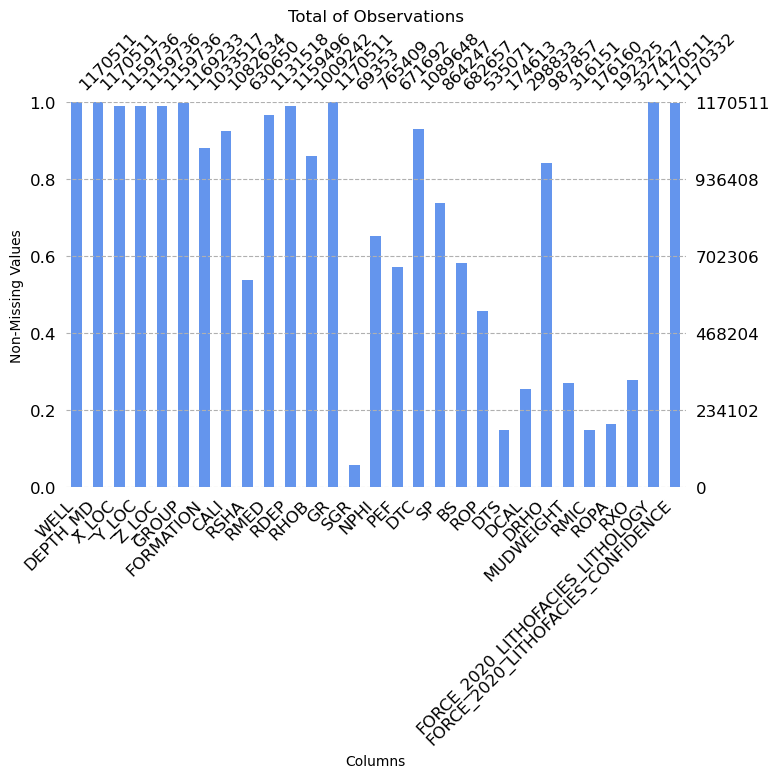

In [6]:
# check for missing values and visualize missingness using a bar plot
fig, axes = plt.subplots(figsize=(8, 5))

msno.bar(df=train, ax=axes, fontsize=12, color='cornflowerblue')

axes.set_xlabel('Columns')
axes.set_ylabel('Non-Missing Values')
axes.set_title('Total of Observations')
axes.grid(axis='y', linestyle='--')

plt.show()

In [7]:
# missing values per column
train.isna().sum()

WELL                                       0
DEPTH_MD                                   0
X_LOC                                  10775
Y_LOC                                  10775
Z_LOC                                  10775
GROUP                                   1278
FORMATION                             136994
CALI                                   87877
RSHA                                  539861
RMED                                   38993
RDEP                                   11015
RHOB                                  161269
GR                                         0
SGR                                  1101158
NPHI                                  405102
PEF                                   498819
DTC                                    80863
SP                                    306264
BS                                    487854
ROP                                   635440
DTS                                   995898
DCAL                                  871678
DRHO      

## 1.3. Data Cleaning

## Renaming Columns

In [8]:
train.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'SGR', 'NPHI', 'PEF',
       'DTC', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC',
       'ROPA', 'RXO', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
       'FORCE_2020_LITHOFACIES_CONFIDENCE'],
      dtype='object')

In [9]:
# rename columns
train.rename(columns={'WELL': 'WELL_ID', 
                      'DEPTH_MD': 'DEPTH',
                      'X_LOC' : 'X',
                      'Y_LOC': 'Y', 
                      'GROUP': 'STRAT'
                     }, inplace=True
            )

test.rename(columns={'WELL': 'WELL_ID', 
                     'DEPTH_MD': 'DEPTH',
                     'X_LOC' : 'X',
                     'Y_LOC': 'Y', 
                     'GROUP': 'STRAT'
                    }, inplace=True
               )

## Dropping Unnecessary Columns

In [10]:
# drop columns
train.drop(['Z_LOC', 'CALI', 'SGR', 'BS', 'ROP', 
            'DCAL', 'MUDWEIGHT', 'RMIC','ROPA', 'RXO', 
            'FORCE_2020_LITHOFACIES_LITHOLOGY',
            'FORCE_2020_LITHOFACIES_CONFIDENCE'], axis=1, inplace=True)

test.drop(['Z_LOC', 'CALI', 'SGR', 'BS', 'ROP', 
            'DCAL', 'MUDWEIGHT', 'RMIC','ROPA', 'RXO', 
            'FORCE_2020_LITHOFACIES_LITHOLOGY',
            'FORCE_2020_LITHOFACIES_CONFIDENCE'], axis=1, inplace=True)

## Handling Outliers and Well-Log Transformation

In [11]:
# create a new column to store log base 10 of resistivity
# train
train['RD10'] = np.log10(train['RDEP']+1)
train['RM10'] = np.log10(train['RMED']+1)
train['RS10'] = np.log10(train['RSHA']+1)

# test
test['RD10'] = np.log10(test['RDEP']+1)
test['RM10'] = np.log10(test['RMED']+1)
test['RS10'] = np.log10(test['RSHA']+1)

## 1.4. Exploratory Data Analysis (EDA)

## Data Summary

In [12]:
# dataset shape
print(f"Number of Samples: {train.shape[0]}")
print(f"Number of Features: {train.shape[1]} \n")

# number of wells
print(f"Number of Wells: {len(train['WELL_ID'].unique())}")

Number of Samples: 1170511
Number of Features: 20 

Number of Wells: 98


In [13]:
cols_statistics = ['WELL_ID', 'DEPTH', 
                   'RHOB', 'GR', 'DTC', 'DTS',
                   'RD10', 'RM10', 'RS10',
                   'SP', 'NPHI','PEF',
                   'FORMATION', 'STRAT']

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170511 entries, 0 to 1170510
Data columns (total 20 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   WELL_ID    1170511 non-null  object 
 1   DEPTH      1170511 non-null  float64
 2   X          1159736 non-null  float64
 3   Y          1159736 non-null  float64
 4   STRAT      1169233 non-null  object 
 5   FORMATION  1033517 non-null  object 
 6   RSHA       630650 non-null   float64
 7   RMED       1131518 non-null  float64
 8   RDEP       1159496 non-null  float64
 9   RHOB       1009242 non-null  float64
 10  GR         1170511 non-null  float64
 11  NPHI       765409 non-null   float64
 12  PEF        671692 non-null   float64
 13  DTC        1089648 non-null  float64
 14  SP         864247 non-null   float64
 15  DTS        174613 non-null   float64
 16  DRHO       987857 non-null   float64
 17  RD10       1159496 non-null  float64
 18  RM10       1131518 non-null  float64
 19  

In [15]:
# descriptive statistics for numerical variables
train[cols_statistics].describe().transpose().round(2)

count     mean     std     min      25%      50%      75%      max
DEPTH  1170511.0  2184.09  997.18  136.09  1418.60  2076.60  2864.39  5436.63
RHOB   1009242.0     2.28    0.25    0.72     2.09     2.32     2.49     3.46
GR     1170511.0    70.91   34.23    0.11    47.63    68.37    89.04  1076.96
DTC    1089648.0   113.36   29.99    7.42    87.83   109.59   140.77   320.48
DTS     174613.0   204.66   71.07   69.16   155.94   188.20   224.65   676.58
RD10   1159496.0     0.48    0.33    0.01     0.28     0.39     0.55     3.30
RM10   1131518.0     0.48    0.30   -0.00     0.28     0.39     0.57     3.30
RS10    630650.0     0.50    0.37    0.00     0.27     0.38     0.61     3.34
SP      864247.0    60.03   76.57 -999.00    32.40    55.39    83.39   526.55
NPHI    765409.0     0.33    0.13   -0.04     0.24     0.33     0.42     1.00
PEF     671692.0     6.32   10.96    0.10     3.41     4.31     5.97   383.13

In [16]:
# descriptive statistics for categorical variables
train[cols_statistics].describe(include=['object']).transpose().round(2)

count unique            top    freq
WELL_ID    1170511     98         25/2-7   25131
FORMATION  1033517     69     Utsira Fm.  172636
STRAT      1169233     14  HORDALAND GP.  293155

In [17]:
# litho
display(round(train['FORMATION'].value_counts() / train.shape[0], 2))

Utsira Fm.               0.15
Kyrre Fm.                0.08
Lista Fm.                0.06
Heather Fm.              0.06
Skade Fm.                0.04
                         ... 
Broom Fm.                0.00
Intra Balder Fm. Sst.    0.00
Farsund Fm.              0.00
Flekkefjord Fm.          0.00
Egersund Fm.             0.00
Name: FORMATION, Length: 69, dtype: float64

In [18]:
# stra
round(train['STRAT'].value_counts() / train.shape[0], 2)

HORDALAND GP.       0.25
SHETLAND GP.        0.20
VIKING GP.          0.11
ROGALAND GP.        0.11
DUNLIN GP.          0.10
NORDLAND GP.        0.10
CROMER KNOLL GP.    0.04
BAAT GP.            0.03
VESTLAND GP.        0.02
HEGRE GP.           0.01
ZECHSTEIN GP.       0.01
BOKNFJORD GP.       0.00
ROTLIEGENDES GP.    0.00
TYNE GP.            0.00
Name: STRAT, dtype: float64

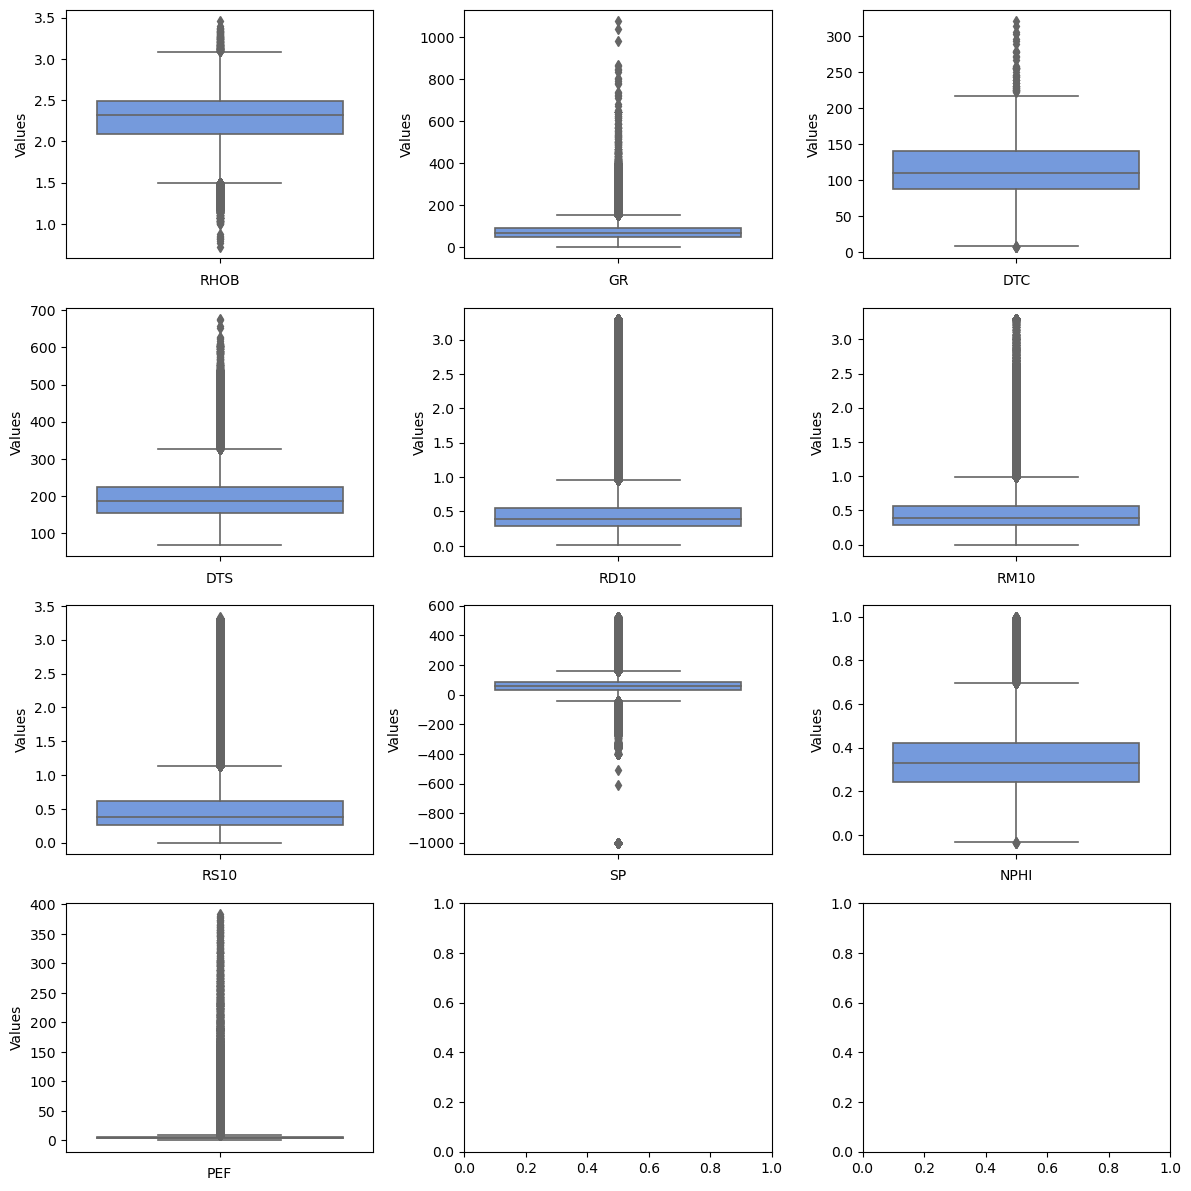

In [19]:
# histogram of well-logs
fig, axes = plt.subplots(4, 3, figsize=(12, 12))
sns.set_context('paper')

sns.boxplot(data=train, y='RHOB', color='cornflowerblue', ax=axes[0,0])
axes[0,0].set_xlabel('RHOB')
axes[0,0].set_ylabel('Values')

sns.boxplot(data=train, y='GR', color='cornflowerblue', ax=axes[0,1])
axes[0,1].set_xlabel('GR')
axes[0,1].set_ylabel('Values')

sns.boxplot(data=train, y='DTC', color='cornflowerblue', ax=axes[0,2])
axes[0,2].set_xlabel('DTC')
axes[0,2].set_ylabel('Values')

sns.boxplot(data=train, y='DTS', color='cornflowerblue', ax=axes[1,0])
axes[1,0].set_xlabel('DTS')
axes[1,0].set_ylabel('Values')

sns.boxplot(data=train, y='RD10', color='cornflowerblue', ax=axes[1,1])
axes[1,1].set_xlabel('RD10')
axes[1,1].set_ylabel('Values')

sns.boxplot(data=train, y='RM10', color='cornflowerblue', ax=axes[1,2])
axes[1,2].set_xlabel('RM10')
axes[1,2].set_ylabel('Values')

sns.boxplot(data=train, y='RS10', color='cornflowerblue', ax=axes[2,0])
axes[2,0].set_xlabel('RS10')
axes[2,0].set_ylabel('Values')

sns.boxplot(data=train, y='SP', color='cornflowerblue', ax=axes[2,1])
axes[2,1].set_xlabel('SP')
axes[2,1].set_ylabel('Values')

sns.boxplot(data=train, y='NPHI', color='cornflowerblue', ax=axes[2,2])
axes[2,2].set_xlabel('NPHI')
axes[2,2].set_ylabel('Values')

sns.boxplot(data=train, y='PEF', color='cornflowerblue', ax=axes[3,0])
axes[3,0].set_xlabel('PEF')
axes[3,0].set_ylabel('Values')

plt.tight_layout()
plt.show()

## Missing Values Analysis

In [20]:
well_logs = ['RHOB', 'GR', 'DTC', 'DTS', 
             'RD10', 'RM10', 'RS10',
             'SP', 'NPHI','PEF']

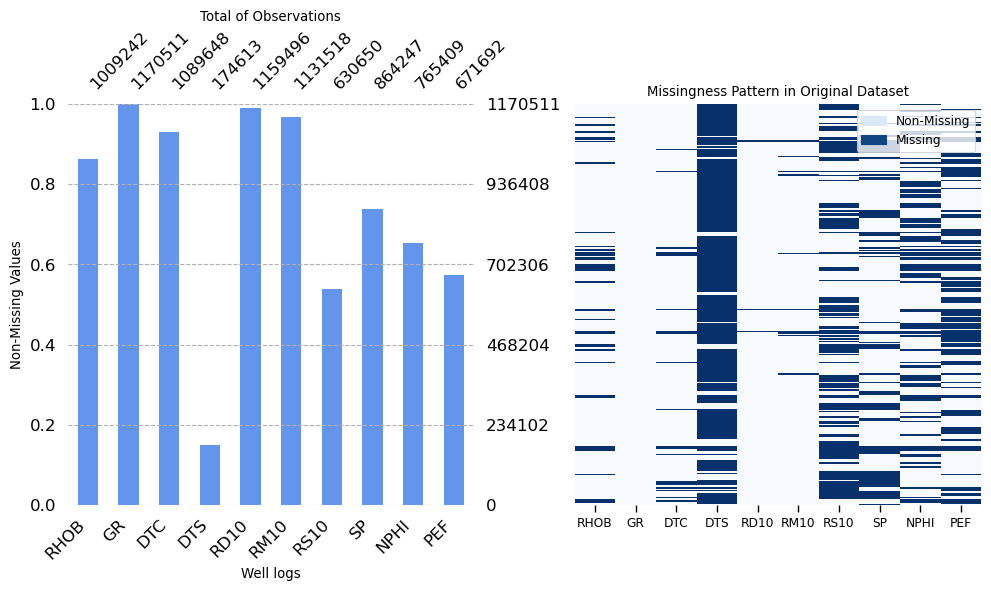

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
sns.set_context('paper')
# missingness bar plot
msno.bar(df=train[well_logs], ax=axes[0], fontsize=12, color='cornflowerblue')
axes[0].set_xlabel('Well logs')
axes[0].set_ylabel('Non-Missing Values')
axes[0].set_title('Total of Observations')
axes[0].grid(axis='y', linestyle='--')

# missingness pattern in well-logs
sns.heatmap(train[well_logs].isna(), yticklabels=False, cbar=False, cmap='Blues', ax=axes[1])
axes[1].legend([plt.Rectangle((0, 0), 1, 1, color=color) for color in ["#DBE9F6", "#124683"]], ['Non-Missing', 'Missing'], frameon=True)
axes[1].set_title('Missingness Pattern in Original Dataset')
plt.tight_layout()
plt.show()

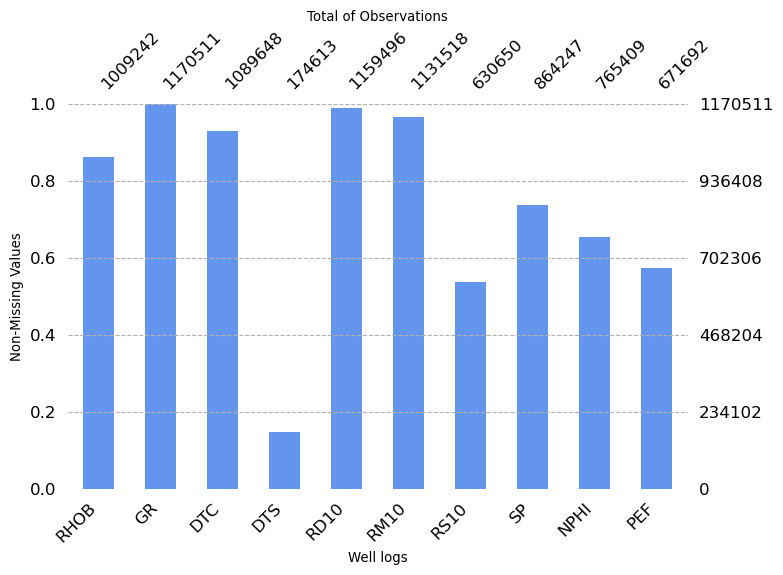

In [22]:
# missingness bar plot
fig, axes = plt.subplots(figsize=(8, 5))

msno.bar(df=train[well_logs], ax=axes, fontsize=12, color='cornflowerblue')

axes.set_xlabel('Well logs')
axes.set_ylabel('Non-Missing Values')
axes.set_title('Total of Observations')
axes.grid(axis='y', linestyle='--')

plt.show()

In [23]:
# check for missing values per column
round(train[well_logs].isna().sum() / train.shape[0], 2)

RHOB    0.14
GR      0.00
DTC     0.07
DTS     0.85
RD10    0.01
RM10    0.03
RS10    0.46
SP      0.26
NPHI    0.35
PEF     0.43
dtype: float64

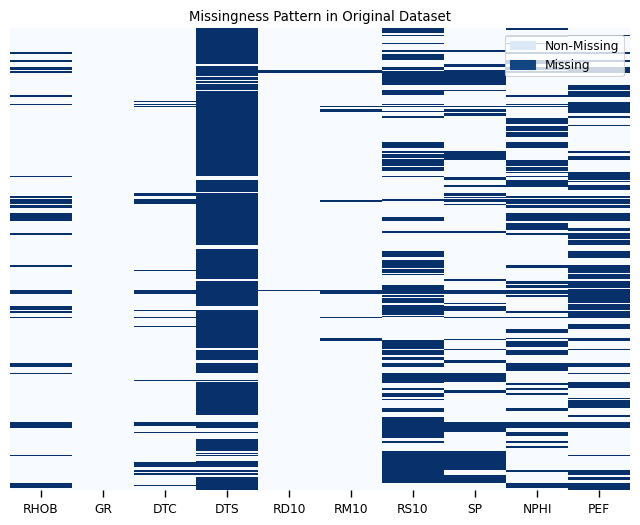

In [24]:
# missingness pattern in well-logs
plt.figure(figsize=(8, 6))
sns.set_context('paper')
axes = sns.heatmap(train[well_logs].isna(), yticklabels=False, 
                 cbar=False, cmap='Blues')
axes.legend([plt.Rectangle((0, 0), 1, 1, color=color) for color in ["#DBE9F6", "#124683"]], ['Non-Missing', 'Missing'], frameon=True)
axes.set_title('Missingness Pattern in Original Dataset')
plt.show()

## Correlation Analysis

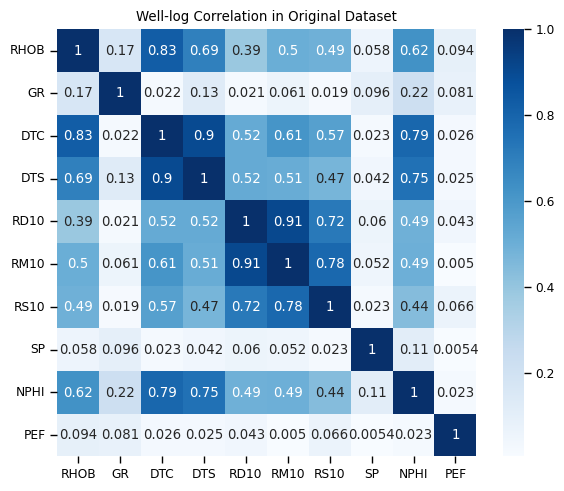

In [25]:
# correlation
train_corr = train[well_logs].corr().abs()
fig = plt.figure(figsize=(6, 5))
sns.set_context('paper')
sns.heatmap(train_corr, cmap='Blues', annot=True)
plt.title('Well-log Correlation in Original Dataset')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [26]:
train_corr

RHOB        GR       DTC       DTS      RD10      RM10      RS10  \
RHOB  1.000000  0.165372  0.825593  0.694566  0.389459  0.502701  0.491149   
GR    0.165372  1.000000  0.022096  0.126999  0.021388  0.060821  0.019386   
DTC   0.825593  0.022096  1.000000  0.902305  0.521221  0.613237  0.565649   
DTS   0.694566  0.126999  0.902305  1.000000  0.520895  0.512866  0.474248   
RD10  0.389459  0.021388  0.521221  0.520895  1.000000  0.907401  0.722740   
RM10  0.502701  0.060821  0.613237  0.512866  0.907401  1.000000  0.784706   
RS10  0.491149  0.019386  0.565649  0.474248  0.722740  0.784706  1.000000   
SP    0.057665  0.095809  0.023432  0.042177  0.059988  0.051718  0.023099   
NPHI  0.623808  0.222430  0.788425  0.749595  0.492081  0.494841  0.436476   
PEF   0.094279  0.080795  0.026209  0.025068  0.043119  0.005003  0.065890   

            SP      NPHI       PEF  
RHOB  0.057665  0.623808  0.094279  
GR    0.095809  0.222430  0.080795  
DTC   0.023432  0.788425  0.026209  
DTS   0.042177  0.749595  0.025068  
RD10  0.059988  0.492081  0.043119  
RM10  0.051718  0.494841  0.005003  
RS10  0.023099  0.436476  0.065890  
SP    1.000000  0.112908  0.005365  
NPHI  0.112908  1.000000  0.022899  
PEF   0.005365  0.022899  1.000000

## Pairplot of Well logs

<Figure size 800x600 with 0 Axes>

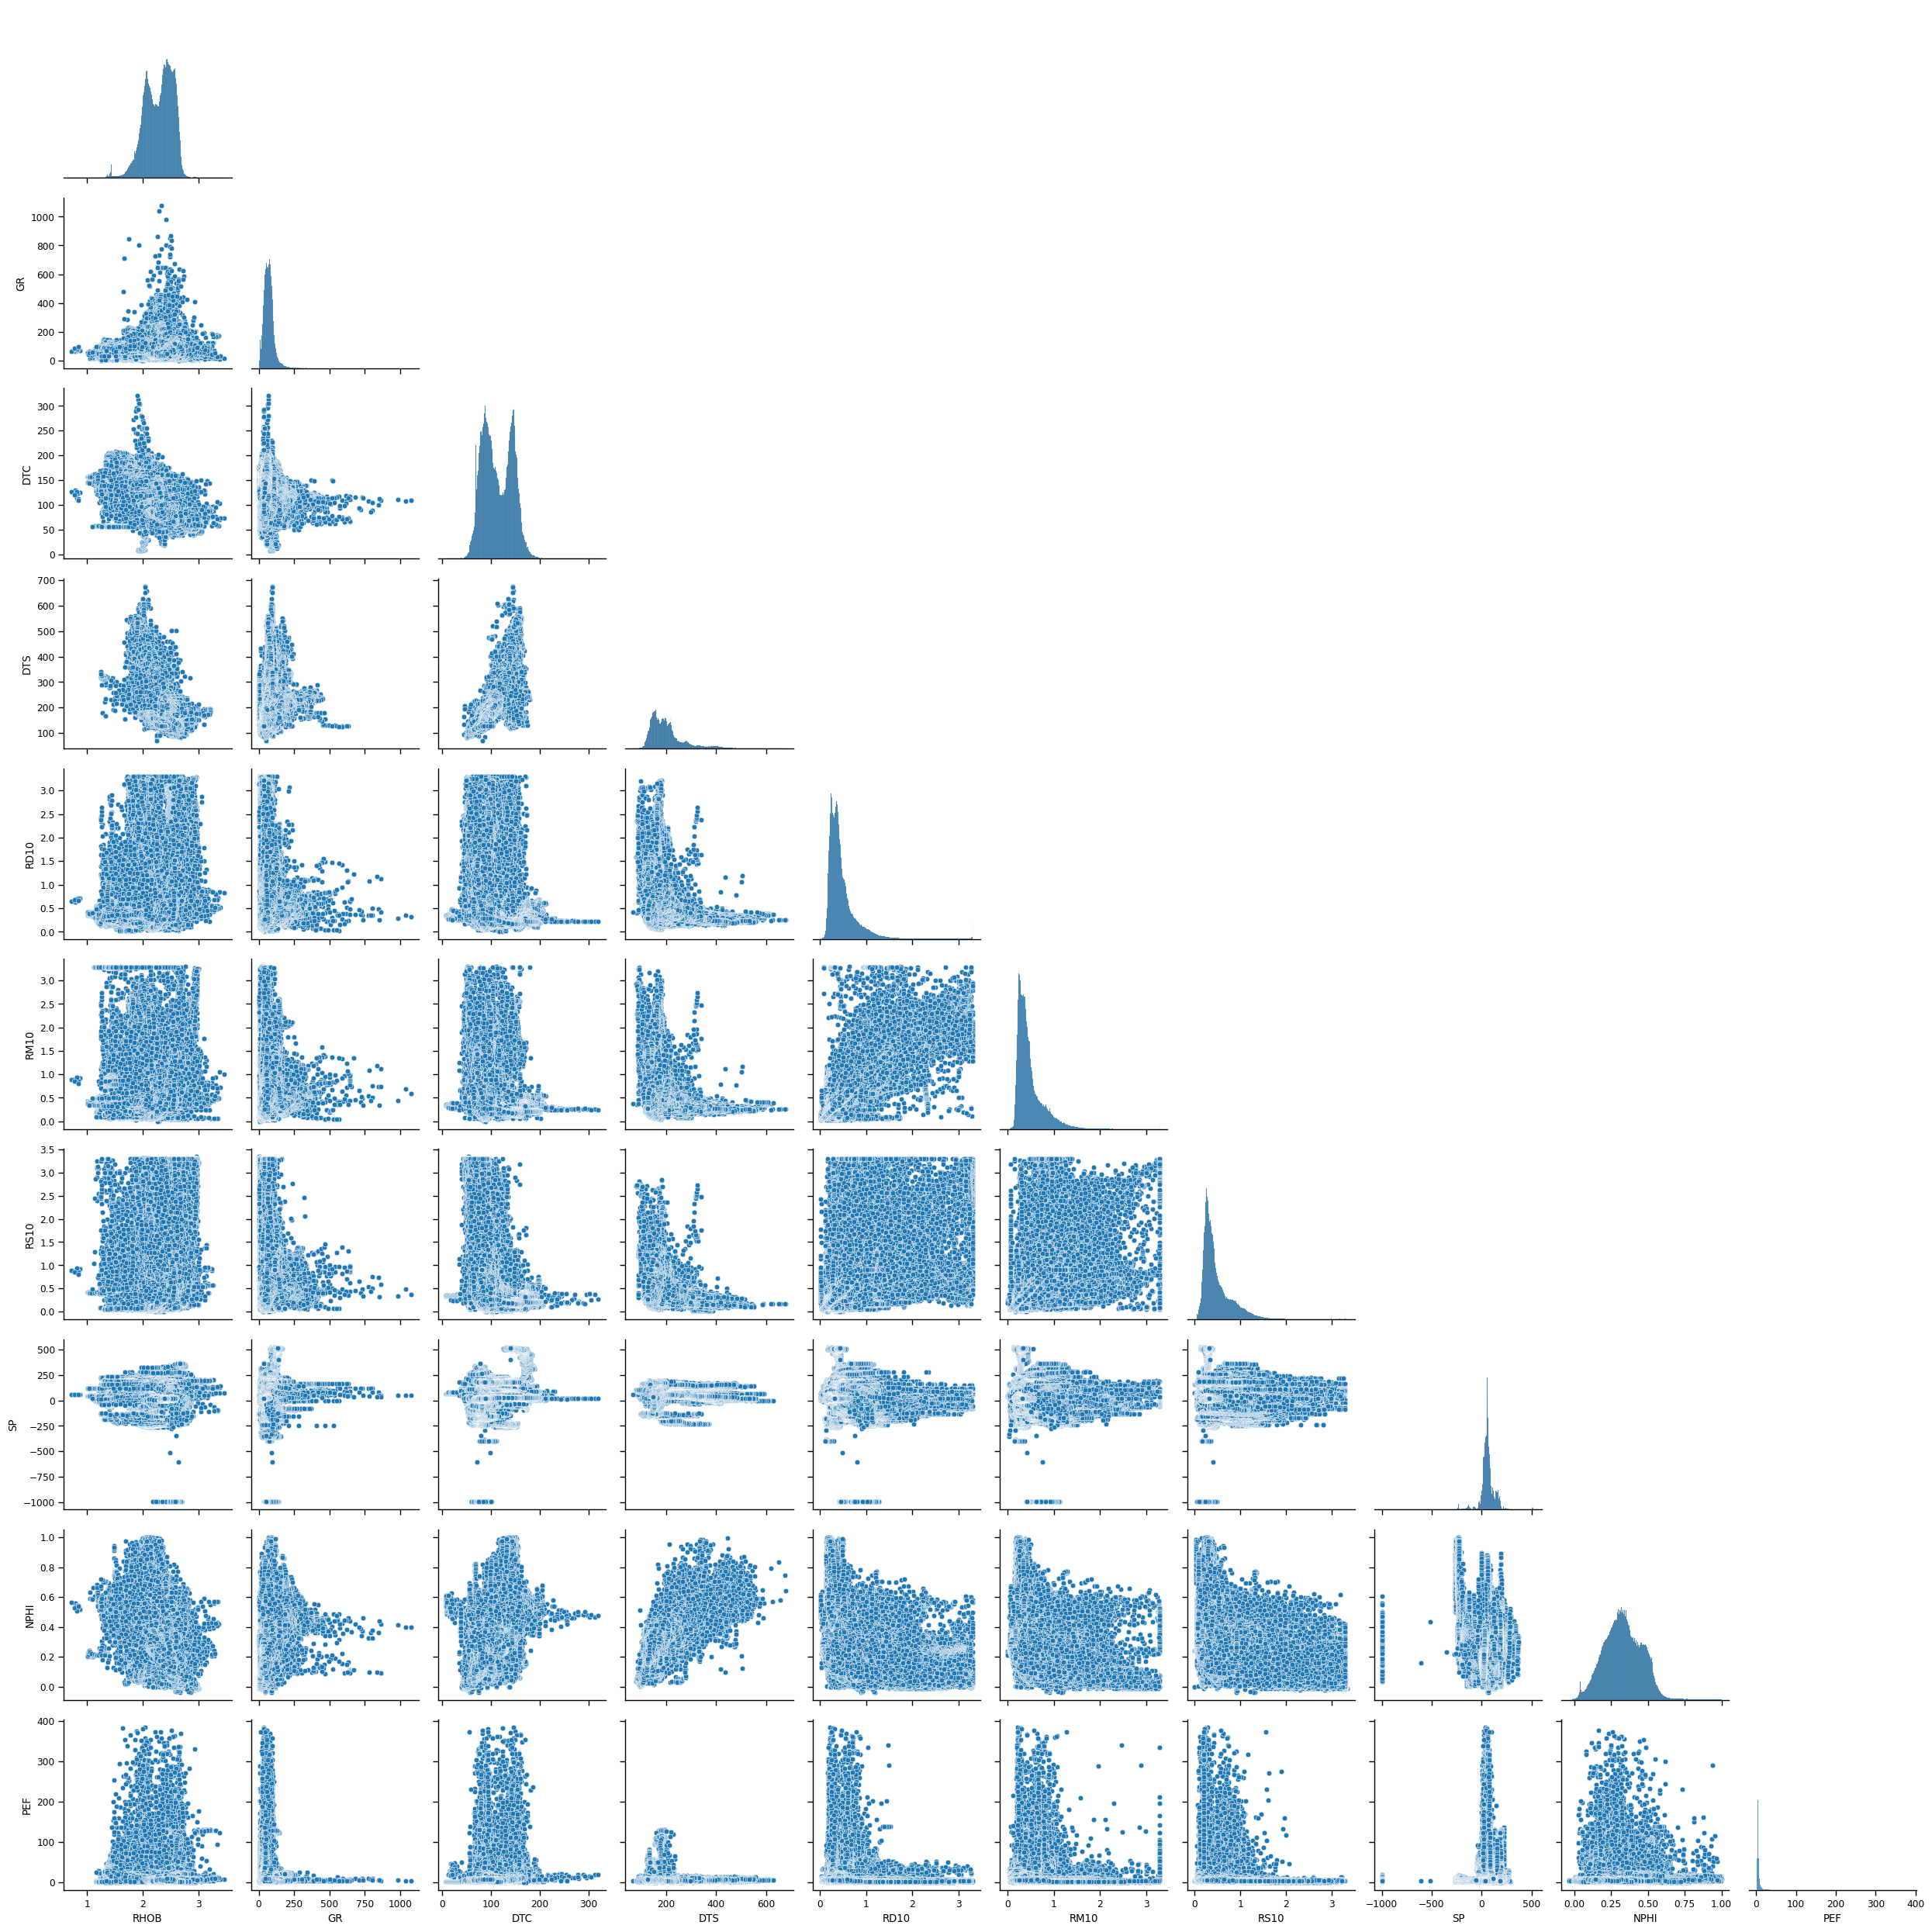

In [27]:
# pairplot of well-logs
fig = plt.figure(figsize=(8, 6))
sns.set_context('paper')
sns.pairplot(train[well_logs], corner=True)
plt.tight_layout()
plt.show()

## 1.5. Feature Engineering and Selection

In [28]:
# label encoding for well id
well_encoder = LabelEncoder()
well_encoder.fit(pd.concat([train, test]).WELL_ID.replace(np.nan, ''))

train['WELL'] = well_encoder.transform(train.WELL_ID.replace(np.nan, ''))
train['WELL'] = train['WELL'].astype(int)

test['WELL'] = well_encoder.transform(test.WELL_ID.replace(np.nan, ''))
test['WELL'] = test['WELL'].astype(int)


# label encoding for stratigraphy
group_encoder = LabelEncoder()
group_encoder.fit(pd.concat([train, test]).STRAT.replace(np.nan, ''))

train['STRAT_ENCODED'] = group_encoder.transform(train.STRAT.replace(np.nan, ''))
train['STRAT_ENCODED'] = train['STRAT_ENCODED'].astype(int)

test['STRAT_ENCODED'] = group_encoder.transform(test.STRAT.replace(np.nan, ''))
test['STRAT_ENCODED'] = test['STRAT_ENCODED'].astype(int)

In [29]:
# columns
train.columns

Index(['WELL_ID', 'DEPTH', 'X', 'Y', 'STRAT', 'FORMATION', 'RSHA', 'RMED',
       'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'DTS', 'DRHO', 'RD10',
       'RM10', 'RS10', 'WELL', 'STRAT_ENCODED'],
      dtype='object')

In [30]:
# feature selection
selected_features = ['WELL', 'X_LOC', 'Y_LOC', 'DEPTH',
                     'RHOB', 'GR', 'DTC', 'DTS',
                     'RD10', 'RM10', 'RS10',
                     'SP', 'NPHI','PEF',
                     'STRAT_ENCODED']

# 2. Data Splitting

## Evaluation of Training and Test Sets

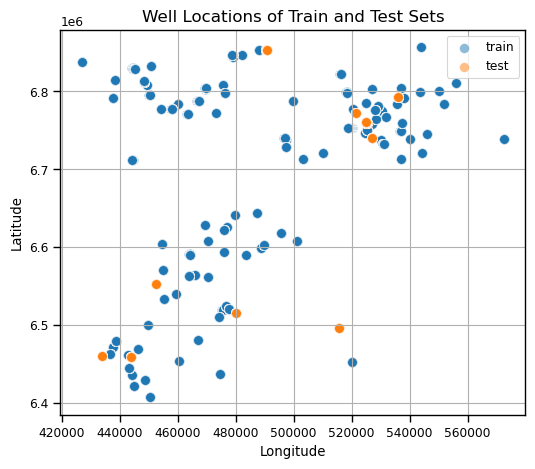

In [31]:
# plotting well locations for train and test sets
plt.figure(figsize=(6, 5))
sns.scatterplot(data=train, x='X', y='Y', alpha=0.5, s=50)
sns.scatterplot(data=test, x='X', y='Y', alpha=0.5, s=50)
plt.title('Well Locations of Train and Test Sets', fontsize=12)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.legend(['train', 'test'])
plt.show()

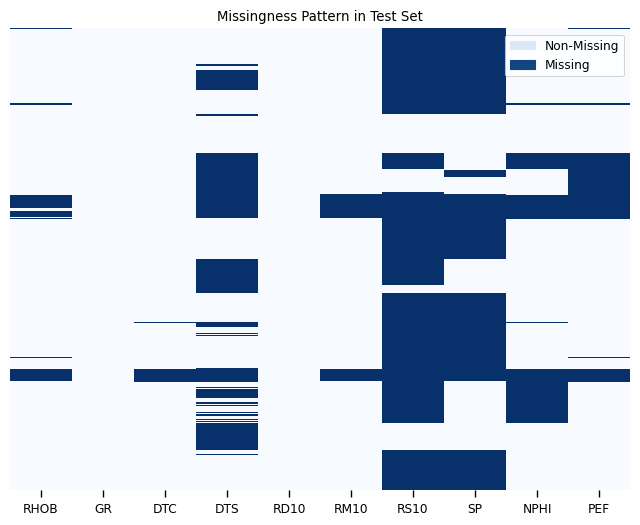

In [32]:
# missingness pattern for the test set
plt.figure(figsize=(8, 6))
sns.set_context('paper')
axes = sns.heatmap(test[well_logs].isna(), yticklabels=False, 
                 cbar=False, cmap='Blues')
axes.set_title('Missingness Pattern in Test Set')
axes.legend([plt.Rectangle((0, 0), 1, 1, color=color) for color in ["#DBE9F6", "#124683"]], ['Non-Missing', 'Missing'], frameon=True)
plt.show()

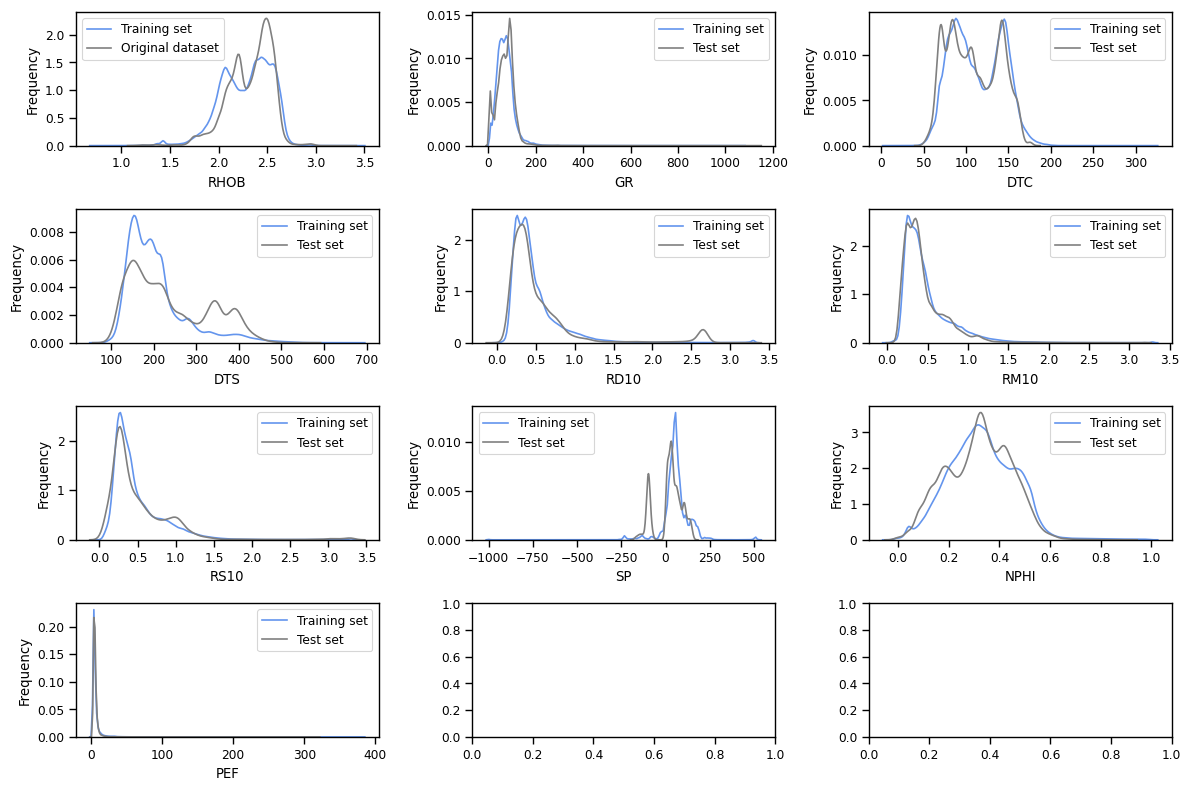

In [33]:
# histogram of well-logs
fig, axes = plt.subplots(4, 3, figsize=(12, 8))
sns.set_context('paper')

sns.kdeplot(train['RHOB'], color='cornflowerblue', ax=axes[0,0], label='Training set')
sns.kdeplot(test['RHOB'], color='grey', ax=axes[0,0], label='Original dataset')
axes[0,0].set_xlabel('RHOB')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()

sns.kdeplot(train['GR'], color='cornflowerblue', ax=axes[0,1], label='Training set')
sns.kdeplot(test['GR'], color='grey', ax=axes[0,1], label='Test set')
axes[0,1].set_xlabel('GR')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()

sns.kdeplot(train['DTC'], color='cornflowerblue', ax=axes[0,2], label='Training set')
sns.kdeplot(test['DTC'], color='grey', ax=axes[0,2], label='Test set')
axes[0,2].set_xlabel('DTC')
axes[0,2].set_ylabel('Frequency')
axes[0,2].legend()

sns.kdeplot(train['DTS'], color='cornflowerblue', ax=axes[1,0], label='Training set')
sns.kdeplot(test['DTS'], color='grey', ax=axes[1,0], label='Test set')
axes[1,0].set_xlabel('DTS')
axes[1,0].set_ylabel('Frequency')
axes[1,0].legend()

sns.kdeplot(train['RD10'], color='cornflowerblue', ax=axes[1,1], label='Training set')
sns.kdeplot(test['RD10'], color='grey', ax=axes[1,1], label='Test set')
axes[1,1].set_xlabel('RD10')
axes[1,1].set_ylabel('Frequency')
axes[1,1].legend()

sns.kdeplot(train['RM10'], color='cornflowerblue', ax=axes[1,2], label='Training set')
sns.kdeplot(test['RM10'], color='grey', ax=axes[1,2], label='Test set')
axes[1,2].set_xlabel('RM10')
axes[1,2].set_ylabel('Frequency')
axes[1,2].legend()

sns.kdeplot(train['RS10'], color='cornflowerblue', ax=axes[2,0], label='Training set')
sns.kdeplot(test['RS10'], color='grey', ax=axes[2,0], label='Test set')
axes[2,0].set_xlabel('RS10')
axes[2,0].set_ylabel('Frequency')
axes[2,0].legend()

sns.kdeplot(train['SP'], color='cornflowerblue', ax=axes[2,1], label='Training set')
sns.kdeplot(test['SP'], color='grey', ax=axes[2,1], label='Test set')
axes[2,1].set_xlabel('SP')
axes[2,1].set_ylabel('Frequency')
axes[2,1].legend()

sns.kdeplot(train['NPHI'], color='cornflowerblue', ax=axes[2,2], label='Training set')
sns.kdeplot(test['NPHI'], color='grey', ax=axes[2,2], label='Test set')
axes[2,2].set_xlabel('NPHI')
axes[2,2].set_ylabel('Frequency')
axes[2,2].legend()

sns.kdeplot(train['PEF'], color='cornflowerblue', ax=axes[3,0], label='Training set')
sns.kdeplot(test['PEF'], color='grey', ax=axes[3,0], label='Test set')
axes[3,0].set_xlabel('PEF')
axes[3,0].set_ylabel('Frequency')
axes[3,0].legend()

plt.tight_layout()
plt.show()

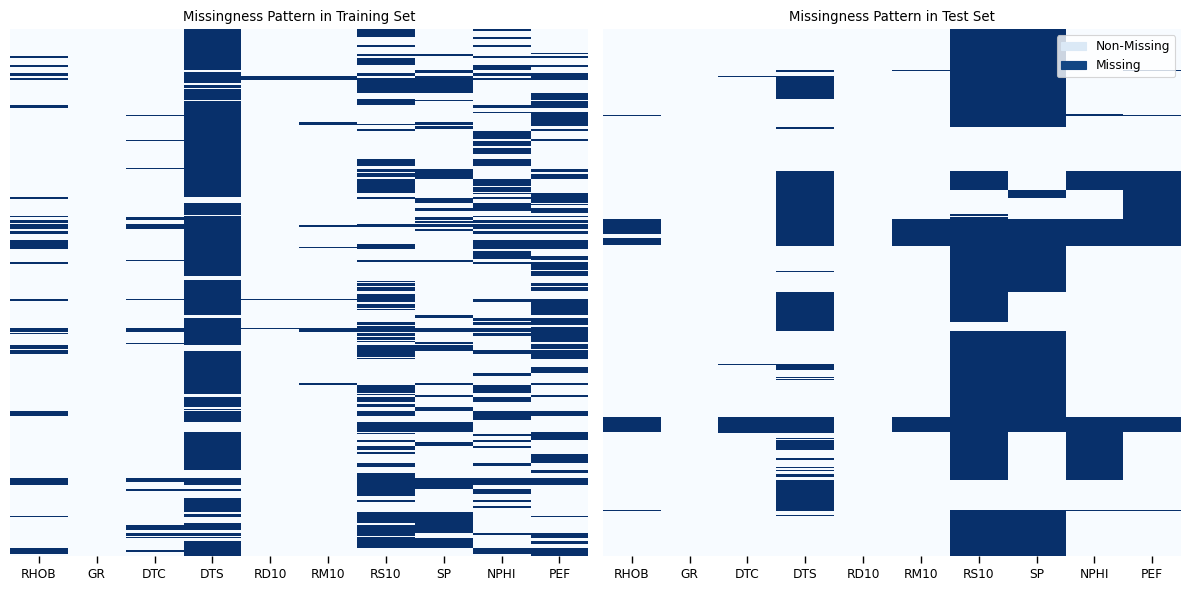

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.set_context('paper')

sns.heatmap(train[well_logs].isna(), yticklabels=False, cbar=False, cmap='Blues', ax=axes[0])
axes[0].set_title('Missingness Pattern in Training Set')


sns.heatmap(test[well_logs].isna(), yticklabels=False, cbar=False, cmap='Blues', ax=axes[1])
axes[1].set_title('Missingness Pattern in Test Set')

axes[1].legend([plt.Rectangle((0, 0), 1, 1, color=color) for color in ["#DBE9F6", "#124683"]], 
          ['Non-Missing', 'Missing'], frameon=True)

plt.tight_layout()
plt.show()

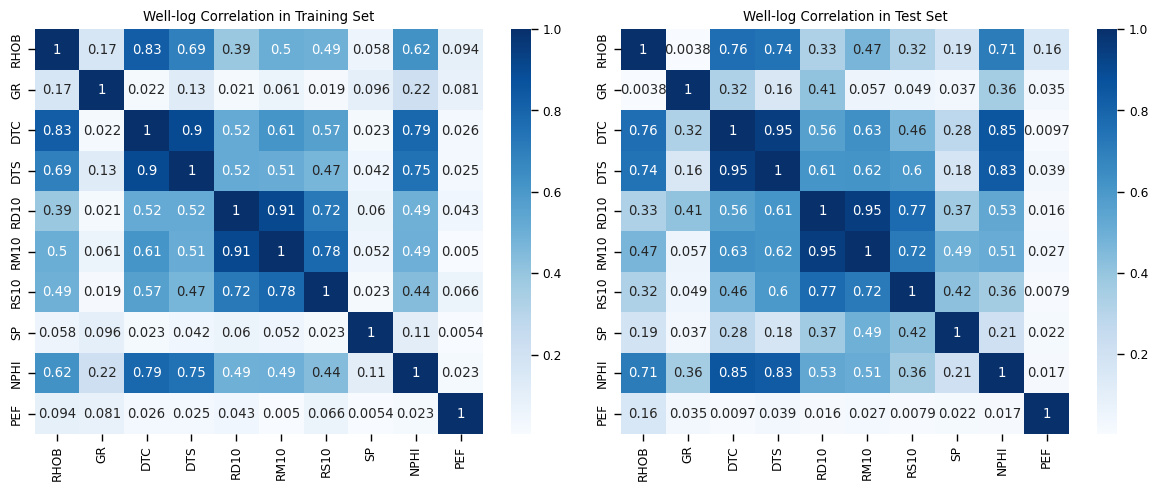

In [35]:
# correlation
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.set_context('paper')

train_corr = train[well_logs].corr().abs()
sns.heatmap(train_corr, cmap='Blues', annot=True, ax=axes[0])
axes[0].set_title('Well-log Correlation in Training Set')

test_corr = test[well_logs].corr().abs()
sns.heatmap(test_corr, cmap='Blues', annot=True, ax=axes[1])
axes[1].set_title('Well-log Correlation in Test Set')

plt.tight_layout()
plt.show()

# 3. Model Training

## 3.1. Input Values

In [36]:
# copy of train and test sets
X_train = train.copy()
X_test = test.copy()

In [37]:
# features to impute 
features_mice = ['RHOB', 'GR', 'DTC', 'DTS', 'RD10', 'RM10', 'RS10', 'SP', 'NPHI', 'PEF', 'STRAT_ENCODED']
imputed_cols = ['RHOB', 'GR', 'DTC', 'DTS', 'RD10', 'RM10', 'RS10', 'SP', 'NPHI']

In [38]:
well_logs = imputed_cols

In [39]:
# list with all combinations of well-logs for each well
unique_wells = X_train['WELL'].unique()
combinations = []
for well in unique_wells:
    for feature in imputed_cols:
        # only for well-logs that are not completely NaN
        if not X_train.loc[X_train['WELL'] == well, feature].isna().all():
            combinations.append((well, feature))
            
print('Number of Combinations:', len(combinations))

Number of Combinations: 761


In [40]:
# function to impute NaN values using iterative imputer (MICE)
def impute(train_data, cols_imp, model):
    mice = IterativeImputer(estimator=model, initial_strategy='mean' , random_state=17, max_iter=10, tol=0.01)
    mice.fit(train_data[cols_imp])
    imputed_train = mice.transform(train_data[cols_imp])
    return imputed_train, mice

## 3.2. Model Training with the best Hyperparameters

In [41]:
def cv_training(X_train, model, param_grid, well_logs, cols_imp, combinations, n_splits, n_jobs):
    """
    Cross-Validation for MICE and Model Evaluation
    
    Parameters
    ---------------------------------------------------------------------------------------------
        X_train: (pd.DataFrame) 
            Training data
        
        model: (model object for imputation)
            Model (e.g., KNeighborsRegressor, BayesianRidge, RF, XGBoost)
            
        param_grid: (dict)
            Dictionary of hyperparameter grids for the model
            
        well_logs: (list)
            List of well logs to evaluate
            
        cols_imp: (list)
            List of columns to impute
            
        combinations: (list)
            List of well and feature combinations
            
        n_splits: (int)
            Number of cross-validation splits
            
        n_jobs: (int)
            Number of jobs to run in parallel during imputation
    
    Returns
    ---------------------------------------------------------------------------------------------
        results: (dict)
            Dictionary containing the evaluation results for each well log
            
        final_time: (float)
            Execution time in seconds
    """  
    kf = KFold(n_splits=n_splits, random_state=17, shuffle=True)
    
    r2_results = {col: [] for col in well_logs}
    mae_results = {col: [] for col in well_logs}
    mse_results = {col: [] for col in well_logs}
    
    start_time = time.time()  # record start time
      
    for i, (train_index, val_index) in enumerate(kf.split(combinations)):

        # train and validations sets
        train_combinations = [combinations[i] for i in train_index]
        validation_combinations = [combinations[i] for i in val_index]

        # copy of the data to work with
        data_train = X_train.copy()

        # set values to NaN in the data to impute using the validation combinations
        for well_id, feature_name in validation_combinations:
            data_train.loc[data_train['WELL']==well_id, feature_name] = np.nan


        # scale the data for training with NaN 
        scaler = MinMaxScaler()
        scaler.fit(data_train[cols_imp])
        X_training_scaled = scaler.transform(data_train[cols_imp])
        X_training_scaled_df = pd.DataFrame(X_training_scaled, 
                                            columns=cols_imp,
                                            index=X_train.index)

        # scale the orignal training data
        X_training_original_scale = scaler.transform(X_train[cols_imp])        
        X_training_original_df = pd.DataFrame(X_training_original_scale, 
                                              columns=cols_imp,
                                              index=X_train.index)
        X_training_original_df['WELL'] = X_train['WELL']
        
        
        # impute NaN values using iterative imputer
        if model == KNeighborsRegressor:
            X_training_imp, imp_model = impute(train_data= X_training_scaled_df,  
                                               cols_imp=cols_imp,
                                               model=model(**param_grid, n_jobs=n_jobs))

        elif model == BayesianRidge:
            X_training_imp, imp_model = impute(train_data=X_training_scaled_df,
                                               cols_imp=cols_imp,
                                               model=model(**param_grid))

        else:
            X_training_imp, imp_model = impute(train_data= X_training_scaled_df,  
                                               cols_imp=cols_imp,
                                               model=model(**param_grid, random_state=17, n_jobs=n_jobs))

        X_training_imp_scaled = pd.DataFrame(X_training_imp, columns=cols_imp, index=X_train.index)

        # evaluate the imputation using validation combinations
        for well_id, feature_name in validation_combinations:         
            original = X_training_original_df.loc[X_training_original_df['WELL']==well_id, feature_name].dropna()
            original_index = list(original.index.values)

            imputed = X_training_imp_scaled.loc[original_index, feature_name]            

            r2 = r2_score(original, imputed)
            r2_results[feature_name].append(r2)
            
            mae = mean_absolute_error(original, imputed)
            mae_results[feature_name].append(mae)
            
            mse = mean_squared_error(original, imputed)
            mse_results[feature_name].append(mse)
    
    results = {'R2': r2_results, 'MAE': mae_results, 'MSE': mse_results}
    
    end_time = time.time()  # record end time
    final_time = end_time - start_time  # final time
    
    return results, final_time

In [42]:
def boxplot_results(results, well_logs_plot):
    
    metrics = list(results.keys())
    
    fig, axes = plt.subplots(nrows=len(metrics), ncols=len(well_logs_plot), figsize=(15, 10))
    
    for i, metric in enumerate(metrics):
        for j, log in enumerate(well_logs_plot):
            
            axes[i,j].boxplot(results[metric][log])
            axes[i,j].set_xlabel(log)
            axes[i,j].set_xticklabels([])
            
            if j == 0:
                axes[i,j].set_ylabel(metric)
        
    plt.tight_layout()
    plt.show()

In [43]:
def training_model(X_train, model, param_grid, well_logs, cols_imp, n_splits, n_jobs):
    """
    Training Model with MICE
    
    Parameters
    ----------------------------------------------------------------------------------
        X_train: (pd.DataFrame) 
            Training data
        
        model: (model object for imputation)
            Model (e.g., KNeighborsRegressor, BayesianRidge, RF, XGBoost)
            
        param_grid: (dict)
            Dictionary of hyperparameters for the model
            
        well_logs: (list)
            List of well logs to evaluate
            
        cols_imp: (list)
            List of columns to impute
            
        n_splits: (int)
            Number of cross-validation splits
            
        n_jobs: (int)
            Number of jobs to run in parallel during imputation
    
    Returns
    ----------------------------------------------------------------------------------
        scaler: (object)
            MinMaxScaler object fitted on the imputed training data
            
        imp_model: (object)
            Trained imputation model
    """
    # copy of the data to work with
    data_train = X_train.copy()

    # scale the data for training
    scaler = MinMaxScaler()
    scaler.fit(data_train[cols_imp])
    X_training_scaled = scaler.transform(data_train[cols_imp])
    X_training_scaled_df = pd.DataFrame(X_training_scaled, 
                                        columns=cols_imp,
                                        index=X_train.index)

    # impute NaN values using iterative imputer
    if model == KNeighborsRegressor:
        X_training_imp, imp_model = impute(train_data= X_training_scaled_df,  
                                           cols_imp=cols_imp,
                                           model=model(**param_grid, n_jobs=n_jobs))

    elif model == BayesianRidge:
        X_training_imp, imp_model = impute(train_data=X_training_scaled_df,
                                           cols_imp=cols_imp,
                                           model=model(**param_grid))

    else:
        X_training_imp, imp_model = impute(train_data= X_training_scaled_df,  
                                           cols_imp=cols_imp,
                                           model=model(**param_grid, random_state=17, n_jobs=n_jobs))

    return scaler, imp_model

### KNeighborsRegressor

In [44]:
param_grid_knr = {}

In [45]:
train_results_knr, train_time_knr = cv_training(X_train=X_train,
                                                model=KNeighborsRegressor, 
                                                param_grid=param_grid_knr,
                                                well_logs=imputed_cols,
                                                cols_imp=features_mice, 
                                                combinations=combinations, 
                                                n_splits=5,
                                                n_jobs=-1)

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [46]:
print('Cross-Validation Time: {:.2f} seconds \n'.format(train_time_knr))

Cross-Validation Time: 22665.23 seconds 



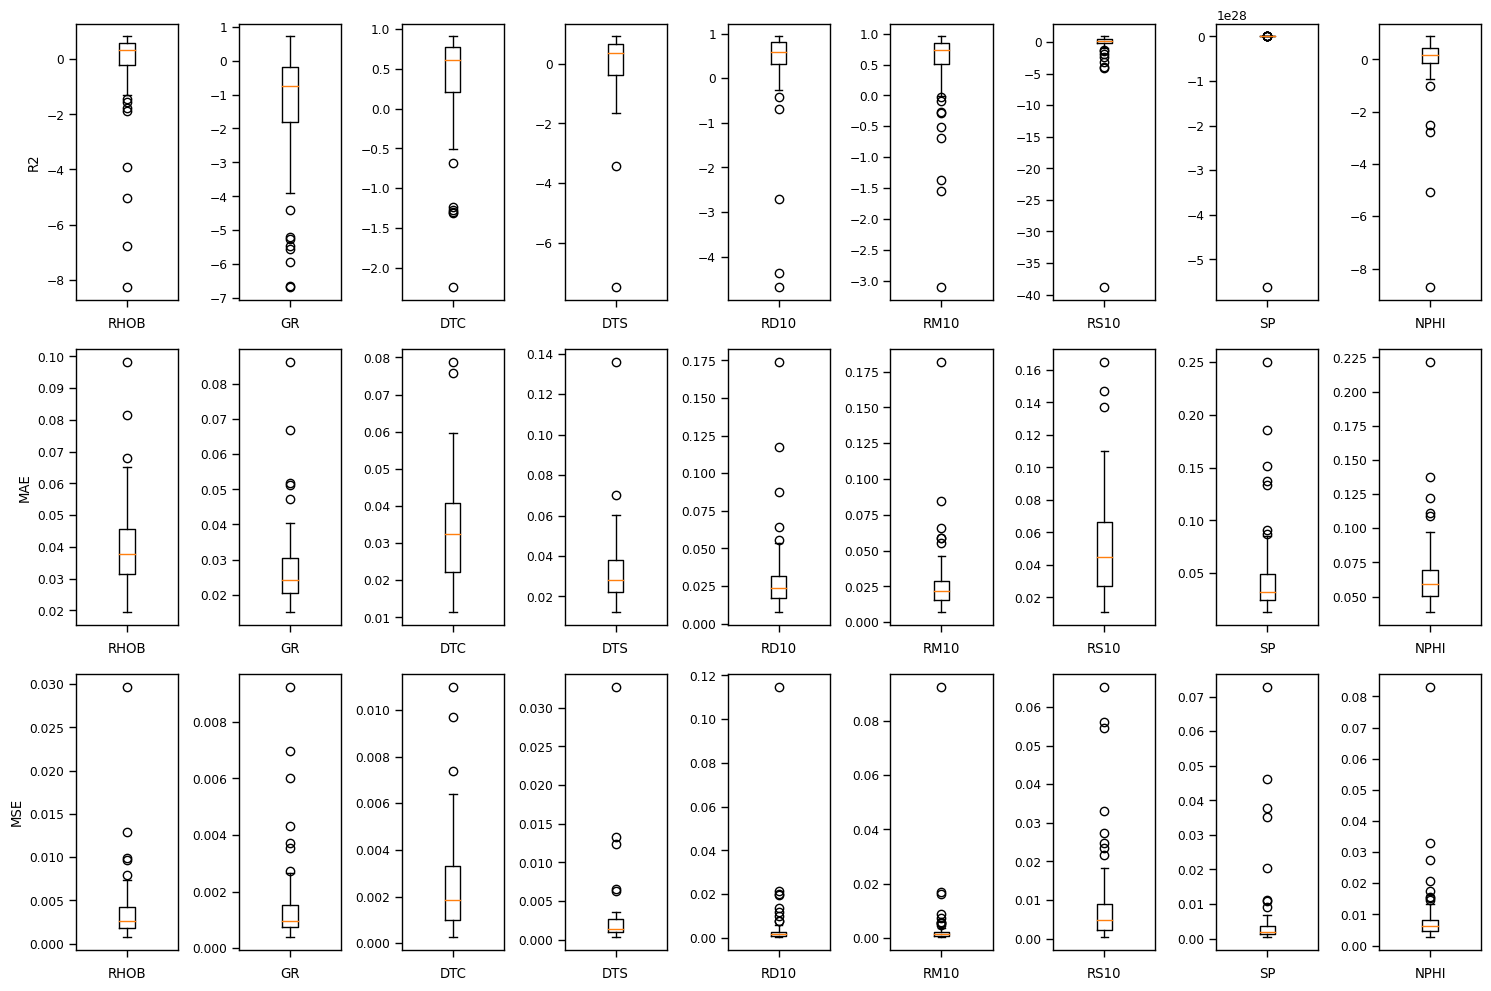

In [47]:
boxplot_results(results=train_results_knr, well_logs_plot=well_logs)

In [48]:
# save training results 
with open('train_results_knr.txt', 'w') as f:
    json.dump(train_results_knr, f)

In [49]:
scaler_knr, imp_model_knr = training_model(X_train=X_train, 
                                           model=KNeighborsRegressor, 
                                           param_grid=param_grid_knr,
                                           well_logs=imputed_cols,
                                           cols_imp=features_mice, 
                                           n_splits=5,
                                           n_jobs=-1)

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### BayesianRidge

In [50]:
param_grid_br = {}

In [51]:
train_results_br, train_time_br = cv_training(X_train=X_train,
                                              model=BayesianRidge, 
                                              param_grid=param_grid_br,
                                              well_logs=imputed_cols,
                                              cols_imp=features_mice, 
                                              combinations=combinations, 
                                              n_splits=5,
                                              n_jobs=-1)

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [52]:
print('Cross-Validation Time: {:.2f} seconds \n'.format(train_time_br))

Cross-Validation Time: 138.60 seconds 



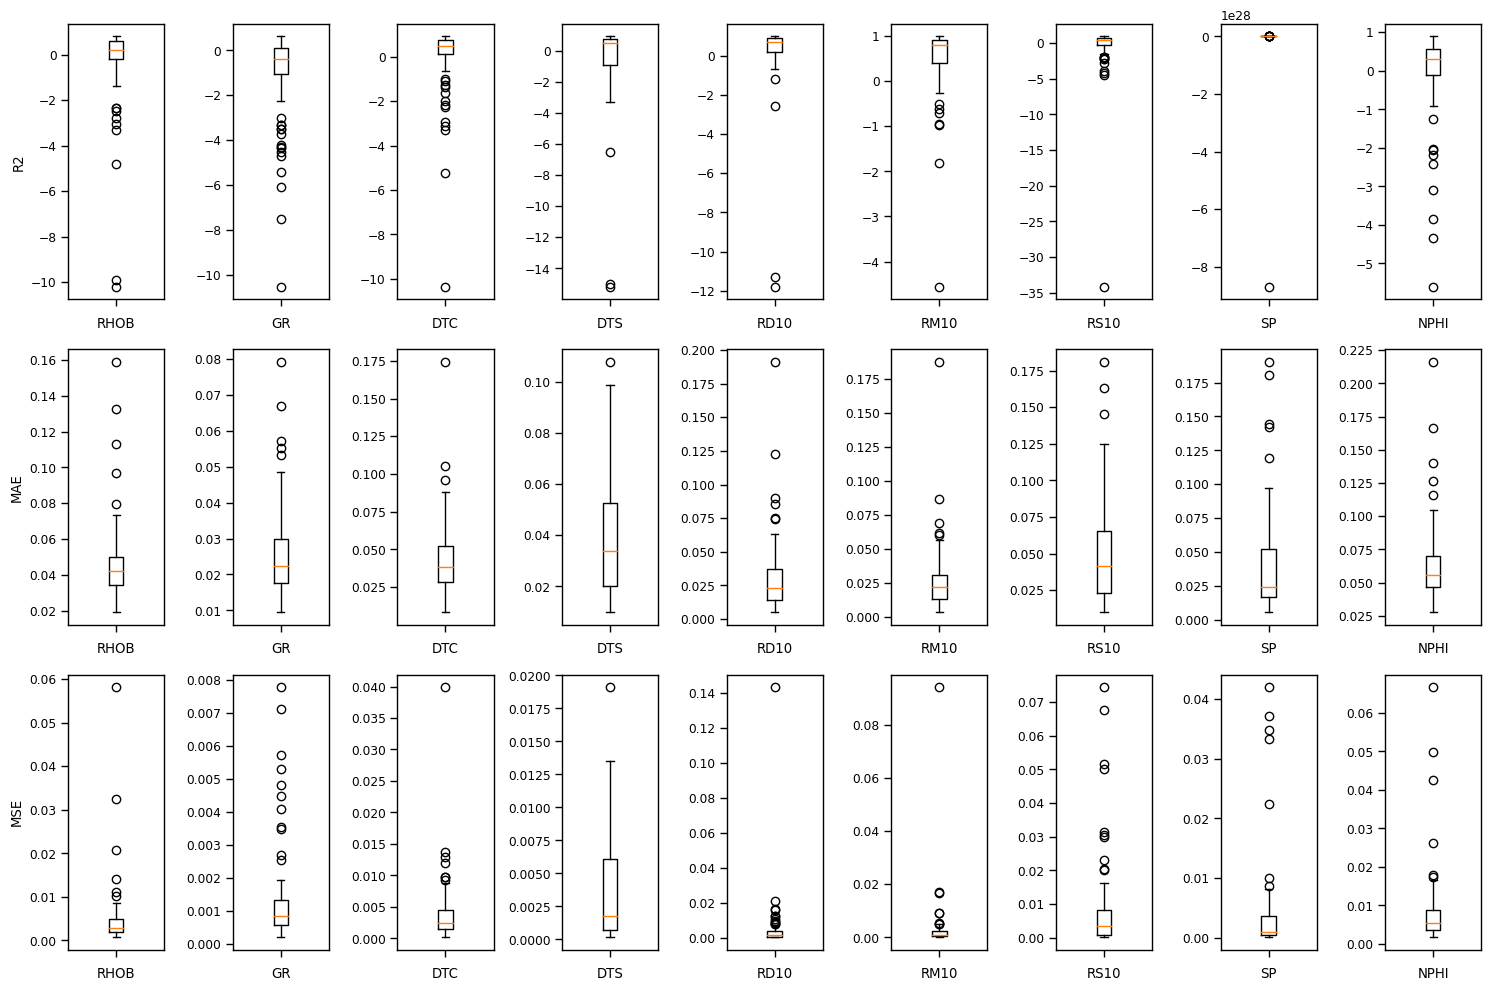

In [53]:
boxplot_results(results=train_results_br, well_logs_plot=well_logs)

In [54]:
# save training results 
with open('train_results_br.txt', 'w') as f:
    json.dump(train_results_br, f)

In [55]:
scaler_br, imp_model_br = training_model(X_train=X_train, 
                                         model=BayesianRidge, 
                                         param_grid=param_grid_br,
                                         well_logs=imputed_cols,
                                         cols_imp=features_mice, 
                                         n_splits=5,
                                         n_jobs=-1)

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### RandomForestRegressor

In [56]:
param_grid_rf = {'max_depth': 10}

In [57]:
train_results_rf, train_time_rf = cv_training(X_train=X_train,
                                              model=RandomForestRegressor, 
                                              param_grid=param_grid_rf,
                                              well_logs=imputed_cols,
                                              cols_imp=features_mice, 
                                              combinations=combinations,
                                              n_splits=5,
                                              n_jobs=-1)

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [58]:
print('Cross-Validation Time: {:.2f} seconds \n'.format(train_time_rf))

Cross-Validation Time: 45745.36 seconds 



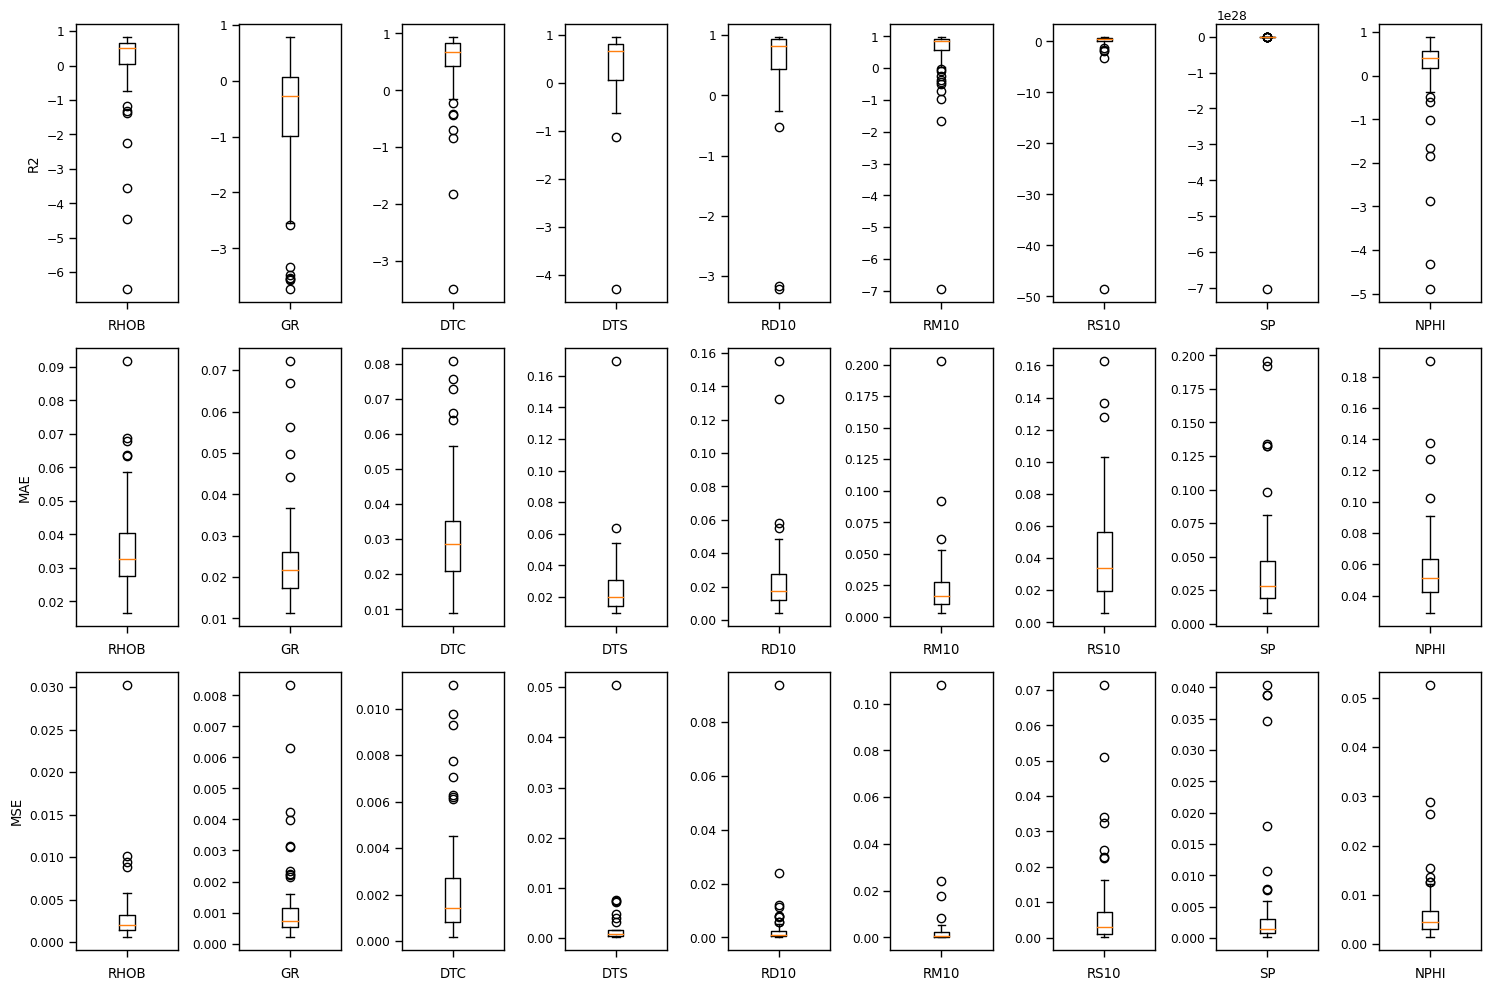

In [59]:
boxplot_results(results=train_results_rf, well_logs_plot=well_logs)

In [60]:
# save training results 
with open('train_results_rf.txt', 'w') as f:
    json.dump(train_results_rf, f)

In [61]:
scaler_rf, imp_model_rf = training_model(X_train=X_train, 
                                         model=RandomForestRegressor, 
                                         param_grid=param_grid_rf,
                                         well_logs=imputed_cols,
                                         cols_imp=features_mice, 
                                         n_splits=5,
                                         n_jobs=-1)

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### XGBRegressor

In [62]:
param_grid_xgb = {}

In [63]:
train_results_xgb, train_time_xgb = cv_training(X_train=X_train,
                                                model=XGBRegressor, 
                                                param_grid=param_grid_xgb,
                                                well_logs=imputed_cols,
                                                cols_imp=features_mice, 
                                                combinations=combinations, 
                                                n_splits=5,
                                                n_jobs=-1)

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [64]:
print('Cross-Validation Time: {:.2f} seconds \n'.format(train_time_xgb))

Cross-Validation Time: 14835.80 seconds 



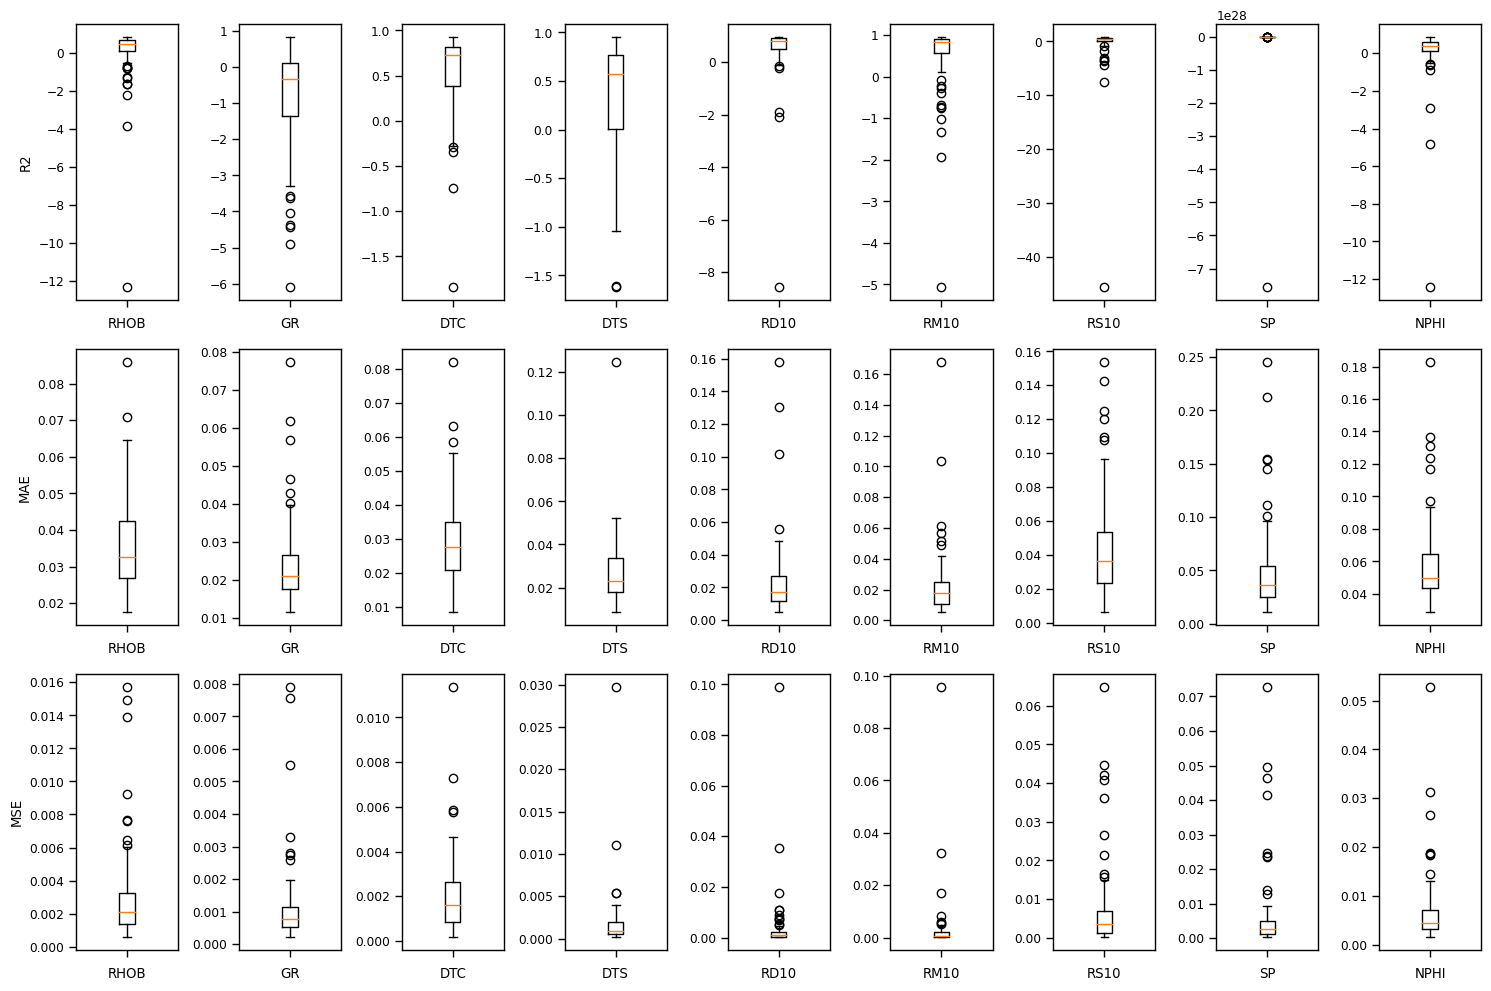

In [65]:
boxplot_results(results=train_results_xgb, well_logs_plot=well_logs)

In [66]:
# save training results 
with open('train_results_xgb.txt', 'w') as f:
    json.dump(train_results_xgb, f)

In [67]:
scaler_xgb, imp_model_xgb = training_model(X_train=X_train, 
                                           model=XGBRegressor, 
                                           param_grid=param_grid_xgb,
                                           well_logs=imputed_cols,
                                           cols_imp=features_mice, 
                                           n_splits=5,
                                           n_jobs=-1)

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


# 4. Testing Imputation

In [68]:
def testing_model(X_test, scaler, imp_model, well_logs, cols_imp, n_splits):
    """
    Impute Test Data using Train Model
    
    Parameters
    ------------------------------------------------------------------------
        X_test: (pd.DataFrame) 
            Test data
        
        scaler: (scaler object)
            Scaler object fitted on the training data
            
        imp_model: (imputation model object)
            Imputation model trained on the training data
            
        well_logs: (list)
            List of well logs to evaluate
            
        cols_imp: (list)
            List of columns to impute
            
        n_splits: (int)
            Number of cross-validation splits
    
    Returns
    ------------------------------------------------------------------------
        combined_df: (pd.DataFrame)
            Combined results dataframe containing original scaled values, 
            scaled imputed values, and imputed values for each well log
    """
    # scale the original test data
    X_test_original_scale = scaler.transform(X_test[cols_imp])        
    X_test_original_scale_df = pd.DataFrame(X_test_original_scale,
                                      columns=cols_imp,
                                      index=X_test.index)
    X_test_original_scale_df['WELL'] = X_test['WELL']
    
    unique_wells = X_test['WELL'].unique()
    combinations = []
    for well in unique_wells:
        for feature in imputed_cols:
            # only for well-logs that are not completely NaN
            if not X_test.loc[X_test['WELL'] == well, feature].isna().all():
                combinations.append((well, feature))
    
    kf = KFold(n_splits=n_splits, random_state=17, shuffle=True)
    
    X_test_sc_imp_result = X_test.copy()
    X_test_imp_result = X_test.copy()
     
    for i, (test_index, val_index) in enumerate(kf.split(combinations)):

        # test and validations sets
        test_combinations = [combinations[i] for i in test_index]
        validation_combinations = [combinations[i] for i in val_index]

        # copy of the data to work with
        data_test = X_test.copy()
        
        # set values to NaN in the data to impute using the validation combinations
        for well_id, feature_name in validation_combinations:
            data_test.loc[data_test['WELL']==well_id, feature_name] = np.nan


        # scale the test with NaN using the scaler object fitted on the training data
        X_test_scaled = scaler.transform(data_test[cols_imp])
        X_test_scaled_df = pd.DataFrame(X_test_scaled, 
                                        columns=cols_imp,
                                        index=X_test.index)

        # impute NaN values in the test data using the imp_model trained on the training data
        X_test_imp = imp_model.transform(X_test_scaled_df[cols_imp])
        X_test_imp_scaled = pd.DataFrame(X_test_imp, columns=cols_imp, index=X_test.index)

        
        # inverse transform the imputed values
        X_test_imp_unscaled = scaler.inverse_transform(X_test_imp_scaled)
        X_test_imp_df = pd.DataFrame(X_test_imp_unscaled, 
                                     columns=cols_imp, 
                                     index=X_test.index)
        
        
        # store results of the scaled imputation using validation combinations
        for well_id, feature_name in validation_combinations:
            scaled_imputed_result = X_test_imp_scaled.loc[X_test['WELL']==well_id, feature_name]
            X_test_sc_imp_result.loc[X_test['WELL']==well_id, feature_name] = scaled_imputed_result
        
        # store results of the imputation using validation combinations
        for well_id, feature_name in validation_combinations:
            imputed_result = X_test_imp_df.loc[X_test['WELL']==well_id, feature_name]
            X_test_imp_result.loc[X_test['WELL']==well_id, feature_name] = imputed_result
                
    # rename columns
    X_test_original_scale_df.rename(columns=lambda x: x + '_SCALED', inplace=True)
    X_test_sc_imp_result.rename(columns=lambda x: x + '_IMP_SCALED', inplace=True)
    X_test_imp_result.rename(columns=lambda x: x + '_IMP', inplace=True)
    
    # combine dataframes
    combined_df = pd.concat([X_test_original_scale_df[[column + '_SCALED' for column in well_logs]],
                             X_test_sc_imp_result[[column + '_IMP_SCALED' for column in well_logs]],
                             X_test_imp_result[[column + '_IMP' for column in well_logs]]
                            ], axis=1)

    return  combined_df

### KNeighborsRegressor

In [69]:
test_result_knr = testing_model(X_test=X_test, 
                                scaler=scaler_knr, 
                                imp_model=imp_model_knr,
                                well_logs=imputed_cols,
                                cols_imp=features_mice,
                                n_splits=5
                               )

In [70]:
# save results to csv file
test_result_knr.to_csv('test_result_knr.csv', index=False)

### BayesianRidge

In [71]:
test_result_br = testing_model(X_test=X_test, 
                               scaler=scaler_br, 
                               imp_model=imp_model_br,
                               well_logs=imputed_cols,
                               cols_imp=features_mice,
                               n_splits=5
                              )

In [72]:
# save results to csv file
test_result_br.to_csv('test_result_br.csv', index=False)

### RandomForestRegressor

In [73]:
test_result_rf = testing_model(X_test=X_test, 
                               scaler=scaler_rf, 
                               imp_model=imp_model_rf,
                               well_logs=imputed_cols,
                               cols_imp=features_mice,
                               n_splits=5
                              )

In [74]:
# save results to csv file
test_result_rf.to_csv('test_result_rf.csv', index=False)

### XGBRegressor

In [75]:
test_result_xgb = testing_model(X_test=X_test, 
                                scaler=scaler_xgb, 
                                imp_model=imp_model_xgb,
                                well_logs=imputed_cols,
                                cols_imp=features_mice,
                                n_splits=5
                               )

In [76]:
# save results to csv file
test_result_xgb.to_csv('test_result_xgb.csv', index=False)